<a href="https://colab.research.google.com/github/Ahmadtjk/Ahmadtjk/blob/main/financial%20risk%20modeling%20on%20the%20S%26P%20500%20companies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Perform financial risk modeling on the S&P 500 companies data from `/content/sp500_companies.csv`, including data loading, cleaning, calculating daily returns, volatility, and Value at Risk (VaR), and visualizing these risk metrics, finally summarizing the key findings.

## Load and Inspect Data

### Subtask:
Load the `/content/sp500_companies.csv` dataset into a pandas DataFrame and display its head, info, and descriptive statistics to understand its structure and content.


**Reasoning**:
First, I'll import the pandas library to enable data manipulation, then load the specified CSV file into a DataFrame. Next, I'll display the head of the DataFrame to quickly inspect the first few rows, followed by its information summary to check data types and non-null counts, and finally, present descriptive statistics to understand the numerical distributions.



In [1]:
import pandas as pd

# Load the dataset into a DataFrame
df = pd.read_csv('/content/sp500_companies.csv')

# Display the first few rows of the DataFrame
print("DataFrame Head:")
print(df.head())

# Display a concise summary of the DataFrame
print("\nDataFrame Info:")
df.info()

# Generate descriptive statistics of the DataFrame
print("\nDataFrame Descriptive Statistics:")
print(df.describe())

DataFrame Head:
  Exchange Symbol              Shortname               Longname  \
0      NMS   AAPL             Apple Inc.             Apple Inc.   
1      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
2      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
3      NMS   AMZN       Amazon.com, Inc.       Amazon.com, Inc.   
4      NMS  GOOGL          Alphabet Inc.          Alphabet Inc.   

                   Sector                        Industry  Currentprice  \
0              Technology            Consumer Electronics        254.49   
1              Technology                  Semiconductors        134.70   
2              Technology       Software - Infrastructure        436.60   
3       Consumer Cyclical                 Internet Retail        224.92   
4  Communication Services  Internet Content & Information        191.41   

       Marketcap        Ebitda  Revenuegrowth           City State  \
0  3846819807232  1.346610e+11          0.061      Cupertino

## Prepare Data for Risk Modeling

### Subtask:
Fetch historical stock price data for the S&P 500 companies, clean this time-series data, handle missing values, and prepare it for calculating daily returns, volatility, and VaR.


**Reasoning**:
The first step is to import the `yfinance` library, which is necessary for downloading historical stock price data. Then, I will extract the unique stock symbols from the `df` DataFrame to prepare for the data download. After that, I will download the historical 'Close' prices for the last 5 years for all extracted symbols using `yfinance` and combine them into a single DataFrame.



In [2]:
import yfinance as yf

# Extract unique stock ticker symbols
symbols = df['Symbol'].unique().tolist()
print(f"Number of unique symbols extracted: {len(symbols)}")

# Download historical daily closing prices for the last 5 years
# We will only keep the 'Close' price and organize by ticker
hist_data = yf.download(symbols, period='5y', group_by='ticker')

# Initialize an empty DataFrame to store combined close prices
combined_close_prices = pd.DataFrame()

# Iterate through each symbol and extract the 'Close' price column
for symbol in symbols:
    # Check if the symbol exists in the downloaded data and has a 'Close' column
    # yfinance can return a tuple for single stock or a DataFrame for multiple stocks
    # If it's a single stock, it's a DataFrame directly
    # If it's multiple stocks, it's a multi-index DataFrame where symbol is the first level
    if (symbol, 'Close') in hist_data.columns:
        combined_close_prices[symbol] = hist_data[symbol]['Close']
    elif symbol in hist_data.columns and 'Close' in hist_data[symbol].columns: # For older versions of yfinance or if there's only one stock downloaded
        combined_close_prices[symbol] = hist_data[symbol]['Close']
    elif symbol in hist_data.index.get_level_values('symbol') and 'Close' in hist_data.columns.get_level_values('Adj Close'):
        # This case handles when yf.download returns a wide format DataFrame with symbol as a level in the columns
        # However, the `group_by='ticker'` argument usually creates a MultiIndex with (symbol, metric)
        # A more robust way to handle single stock download if it doesn't return a MultiIndex
        if isinstance(hist_data, pd.DataFrame) and 'Close' in hist_data.columns and len(symbols) == 1:
            combined_close_prices[symbol] = hist_data['Close']
        else:
            print(f"Warning: Could not find 'Close' price for {symbol}")
    else:
        print(f"Warning: Symbol {symbol} or its 'Close' price not found in downloaded data.")


# Display the head of the combined close prices DataFrame
print("\nCombined Historical Close Prices Head:")
print(combined_close_prices.head())

Number of unique symbols extracted: 502


/tmp/ipython-input-307445046.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hist_data = yf.download(symbols, period='5y', group_by='ticker')
[*********************100%***********************]  502 of 502 completed
ERROR:yfinance:
9 Failed downloads:
ERROR:yfinance:['DFS', 'JNPR', 'ANSS', 'IPG', 'FI', 'WBA', 'K', 'PARA', 'HES']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
/tmp/ipython-input-307445046.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_close_prices[symbol] = hist_data[symbol]['Close']
/tmp/ipython-input-307445046.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin


Combined Historical Close Prices Head:
                  AAPL       NVDA        MSFT        AMZN       GOOGL  \
Date                                                                    
2021-02-22  122.723442  14.315493  225.539902  159.037003  101.942749   
2021-02-23  122.587090  14.102343  224.347382  159.725006  102.233543   
2021-02-24  122.090347  14.458340  225.578445  157.976501  103.409172   
2021-02-25  117.843719  13.270183  220.231079  152.858002  100.041611   
2021-02-26  118.106697  13.676042  223.491440  154.646500  100.337364   

                  GOOG        META        TSLA       AVGO       BRK-B  ...  \
Date                                                                   ...   
2021-02-22  102.475426  258.524109  238.166672  42.853706  244.970001  ...   
2021-02-23  102.772186  264.015747  232.946671  42.452477  245.529999  ...   
2021-02-24  103.978645  262.476562  247.339996  43.260330  248.449997  ...   
2021-02-25  100.811890  252.923248  227.406662  41.126450 

**Reasoning**:
The previous code generated a `PerformanceWarning` and had a complex loop for extracting 'Close' prices from the `hist_data` MultiIndex DataFrame. I will simplify this extraction using `xs` for better efficiency and correctness. Then, as per the subtask instructions, I will address missing values by dropping columns with all `NaN` values (failed downloads) and forward-filling, then backward-filling, any remaining `NaN`s to ensure a complete time series. Finally, I will ensure the index is of datetime type and display the head and info of the cleaned DataFrame.



In [3]:
import yfinance as yf
import pandas as pd

# Extract unique stock ticker symbols
symbols = df['Symbol'].unique().tolist()
print(f"Number of unique symbols extracted: {len(symbols)}")

# Download historical daily closing prices for the last 5 years
# auto_adjust=True returns adjusted close prices, which is generally preferred.
# However, the task specifically asks for 'Close' price, and yfinance often provides 'Close' alongside 'Adj Close'.
# Let's keep group_by='ticker' which creates a MultiIndex for columns.
hist_data = yf.download(symbols, period='5y', group_by='ticker')

# Extract only the 'Close' prices for all symbols
# hist_data.columns is a MultiIndex (Symbol, Metric)
# We want all Symbols, but only the 'Close' metric
combined_close_prices = hist_data.xs('Close', axis=1, level=1)

# Drop columns (stocks) that have all NaN values (failed downloads or no data for the period)
initial_columns = combined_close_prices.shape[1]
combined_close_prices.dropna(axis=1, how='all', inplace=True)
dropped_columns = initial_columns - combined_close_prices.shape[1]
print(f"Dropped {dropped_columns} stocks due to entirely missing data.")

# Handle any remaining missing values using forward fill then backward fill
# This fills NaNs with the previous valid observation, then fills any remaining (at the start) with the next valid observation.
combined_close_prices.fillna(method='ffill', inplace=True)
combined_close_prices.fillna(method='bfill', inplace=True)

# Verify index is datetime type (yfinance usually returns DatetimeIndex)
if not isinstance(combined_close_prices.index, pd.DatetimeIndex):
    combined_close_prices.index = pd.to_datetime(combined_close_prices.index)

# Display the head of the cleaned combined close prices DataFrame
print("\nCleaned Combined Historical Close Prices Head:")
print(combined_close_prices.head())
print("\nCleaned Combined Historical Close Prices Info:")
combined_close_prices.info()


Number of unique symbols extracted: 502


/tmp/ipython-input-3192971028.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hist_data = yf.download(symbols, period='5y', group_by='ticker')
[*********************100%***********************]  502 of 502 completed
ERROR:yfinance:
9 Failed downloads:
ERROR:yfinance:['DFS', 'JNPR', 'IPG', 'ANSS', 'FI', 'WBA', 'K', 'PARA', 'HES']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')


Dropped 9 stocks due to entirely missing data.

Cleaned Combined Historical Close Prices Head:
Ticker             TYL       DELL        KHC         LHX        WDC  \
Date                                                                  
2021-02-22  459.619995  37.364960  29.510559  170.092163  51.096508   
2021-02-23  462.119995  37.267799  29.423365  169.649612  50.561901   
2021-02-24  473.190002  37.790550  29.803843  172.855957  53.106934   
2021-02-25  461.309998  36.860699  29.542261  168.899963  51.043804   
2021-02-26  463.420013  37.503731  28.836805  164.302597  51.600998   

Ticker             ZBH        OXY        AOS         SYK         FE  ...  \
Date                                                                 ...   
2021-02-22  149.431778  24.942917  56.515148  230.924454  27.627731  ...   
2021-02-23  150.857697  24.556570  56.432896  234.162949  27.342323  ...   
2021-02-24  152.553879  26.535418  56.012592  236.309372  27.929459  ...   
2021-02-25  153.308777  25.

/tmp/ipython-input-3192971028.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_close_prices.dropna(axis=1, how='all', inplace=True)
/tmp/ipython-input-3192971028.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_close_prices.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3192971028.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_close_prices.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3192971028.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will

**Reasoning**:
To resolve the `SettingWithCopyWarning` and ensure that modifications are made on an independent copy of the DataFrame, I will explicitly create a copy of `combined_close_prices` after extracting the 'Close' prices.



In [4]:
import yfinance as yf
import pandas as pd

# Extract unique stock ticker symbols
symbols = df['Symbol'].unique().tolist()
print(f"Number of unique symbols extracted: {len(symbols)}")

# Download historical daily closing prices for the last 5 years
# auto_adjust=True returns adjusted close prices, which is generally preferred.
# However, the task specifically asks for 'Close' price, and yfinance often provides 'Close' alongside 'Adj Close'.
# Let's keep group_by='ticker' which creates a MultiIndex for columns.
hist_data = yf.download(symbols, period='5y', group_by='ticker')

# Extract only the 'Close' prices for all symbols and create a true copy to avoid SettingWithCopyWarning
# hist_data.columns is a MultiIndex (Symbol, Metric)
# We want all Symbols, but only the 'Close' metric
combined_close_prices = hist_data.xs('Close', axis=1, level=1).copy()

# Drop columns (stocks) that have all NaN values (failed downloads or no data for the period)
initial_columns = combined_close_prices.shape[1]
combined_close_prices.dropna(axis=1, how='all', inplace=True)
dropped_columns = initial_columns - combined_close_prices.shape[1]
print(f"Dropped {dropped_columns} stocks due to entirely missing data.")

# Handle any remaining missing values using forward fill then backward fill
# This fills NaNs with the previous valid observation, then fills any remaining (at the start) with the next valid observation.
combined_close_prices.fillna(method='ffill', inplace=True)
combined_close_prices.fillna(method='bfill', inplace=True)

# Verify index is datetime type (yfinance usually returns DatetimeIndex)
if not isinstance(combined_close_prices.index, pd.DatetimeIndex):
    combined_close_prices.index = pd.to_datetime(combined_close_prices.index)

# Display the head of the cleaned combined close prices DataFrame
print("\nCleaned Combined Historical Close Prices Head:")
print(combined_close_prices.head())
print("\nCleaned Combined Historical Close Prices Info:")
combined_close_prices.info()


Number of unique symbols extracted: 502


/tmp/ipython-input-3303904607.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hist_data = yf.download(symbols, period='5y', group_by='ticker')
[*********************100%***********************]  502 of 502 completed
ERROR:yfinance:
9 Failed downloads:
ERROR:yfinance:['DFS', 'JNPR', 'IPG', 'ANSS', 'FI', 'WBA', 'K', 'PARA', 'HES']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')


Dropped 9 stocks due to entirely missing data.

Cleaned Combined Historical Close Prices Head:
Ticker             TYL       DELL          L        PNW        WDC  \
Date                                                                 
2021-02-22  459.619995  37.364941  48.561275  59.820023  51.096508   
2021-02-23  462.119995  37.267803  49.576378  60.549828  50.561901   
2021-02-24  473.190002  37.790546  49.507591  58.592987  53.106934   
2021-02-25  461.309998  36.860706  47.886162  58.576950  51.043804   
2021-02-26  463.420013  37.503731  46.982094  56.082771  51.600998   

Ticker             ZBH        OXY        AOS         SYK         FE  ...  \
Date                                                                 ...   
2021-02-22  149.431747  24.942919  56.515144  230.924469  27.627735  ...   
2021-02-23  150.857681  24.556572  56.432899  234.162979  27.342323  ...   
2021-02-24  152.553879  26.535421  56.012577  236.309357  27.929457  ...   
2021-02-25  153.308777  25.206766 

/tmp/ipython-input-3303904607.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_close_prices.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3303904607.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_close_prices.fillna(method='bfill', inplace=True)


**Reasoning**:
With the historical closing prices successfully downloaded and cleaned, the next logical step according to the overall task and subtask description is to calculate the daily returns for each stock, which is a fundamental metric for financial risk analysis.



In [5]:
import numpy as np

# Calculate daily returns
daily_returns = combined_close_prices.pct_change()

# Display the head of the daily returns DataFrame
print("\nDaily Returns Head:")
print(daily_returns.head())

# Display descriptive statistics of daily returns
print("\nDaily Returns Descriptive Statistics:")
print(daily_returns.describe())



Daily Returns Head:
Ticker           TYL      DELL         L       PNW       WDC       ZBH  \
Date                                                                     
2021-02-22       NaN       NaN       NaN       NaN       NaN       NaN   
2021-02-23  0.005439 -0.002600  0.020904  0.012200 -0.010463  0.009542   
2021-02-24  0.023955  0.014027 -0.001387 -0.032318  0.050335  0.011244   
2021-02-25 -0.025106 -0.024605 -0.032751 -0.000274 -0.038849  0.004948   
2021-02-26  0.004574  0.017445 -0.018880 -0.042580  0.010916 -0.008754   

Ticker           OXY       AOS       SYK        FE  ...       XYL       PSA  \
Date                                                ...                       
2021-02-22       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2021-02-23 -0.015489 -0.001455  0.014024 -0.010331  ... -0.006333  0.019263   
2021-02-24  0.080583 -0.007448  0.009166  0.021473  ...  0.022661  0.001114   
2021-02-25 -0.050071 -0.017455 -0.012218 -0.021606  ... -0.010782

**Reasoning**:
With daily returns calculated, the next logical step in preparing the data for risk modeling is to calculate the volatility of these returns. Volatility, typically measured as the standard deviation of daily returns, is a key component for understanding risk and will be used later for VaR calculations.



In [6]:
import numpy as np

# Calculate daily volatility (standard deviation of daily returns)
volatility = daily_returns.std()

# Display the volatility for each stock
print("\nDaily Volatility (Standard Deviation of Daily Returns):")
print(volatility.head())
print(f"\nMean Volatility: {volatility.mean():.4f}")
print(f"Median Volatility: {volatility.median():.4f}")


Daily Volatility (Standard Deviation of Daily Returns):
Ticker
TYL     0.019959
DELL    0.028373
L       0.012455
PNW     0.013060
WDC     0.029697
dtype: float64

Mean Volatility: 0.0193
Median Volatility: 0.0180


**Reasoning**:
With daily returns and volatility calculated, the final step in preparing the data for risk modeling, as per the subtask, is to calculate the Value at Risk (VaR). I will calculate VaR at a 95% confidence level for each stock using the historical method, which involves finding the 5th percentile of the daily returns. This metric provides an estimate of potential losses.



In [7]:
import scipy.stats as ss

# Calculate Value at Risk (VaR) at 95% confidence level
# VaR is typically expressed as a positive number representing a potential loss
var_95 = daily_returns.quantile(0.05)

# Display the VaR for each stock
print("
Daily VaR at 95% Confidence Level:")
print(var_95.head())
print(f"\nMean VaR: {var_95.mean():.4f}")
print(f"Median VaR: {var_95.median():.4f}")


SyntaxError: unterminated string literal (detected at line 8) (ipython-input-675919762.py, line 8)

**Reasoning**:
The previous code block failed due to a `SyntaxError: unterminated string literal` in a `print` statement. I will fix the string literal to be on a single line for correct syntax.



In [8]:
import scipy.stats as ss

# Calculate Value at Risk (VaR) at 95% confidence level
# VaR is typically expressed as a positive number representing a potential loss
var_95 = daily_returns.quantile(0.05)

# Display the VaR for each stock
print("Daily VaR at 95% Confidence Level:")
print(var_95.head())
print(f"\nMean VaR: {var_95.mean():.4f}")
print(f"Median VaR: {var_95.median():.4f}")

Daily VaR at 95% Confidence Level:
Ticker
TYL    -0.030314
DELL   -0.038228
L      -0.019973
PNW    -0.021220
WDC    -0.039124
Name: 0.05, dtype: float64

Mean VaR: -0.0285
Median VaR: -0.0266


## Visualize Risk Metrics

### Subtask:
Visualize the daily returns, historical volatility, and the distribution of returns for selected stocks.


**Reasoning**:
To begin visualizing the risk metrics, I will import the necessary plotting libraries, `matplotlib.pyplot` and `seaborn`, as instructed. Then, I will select a few key stock symbols for detailed visualization of their daily returns and distributions.



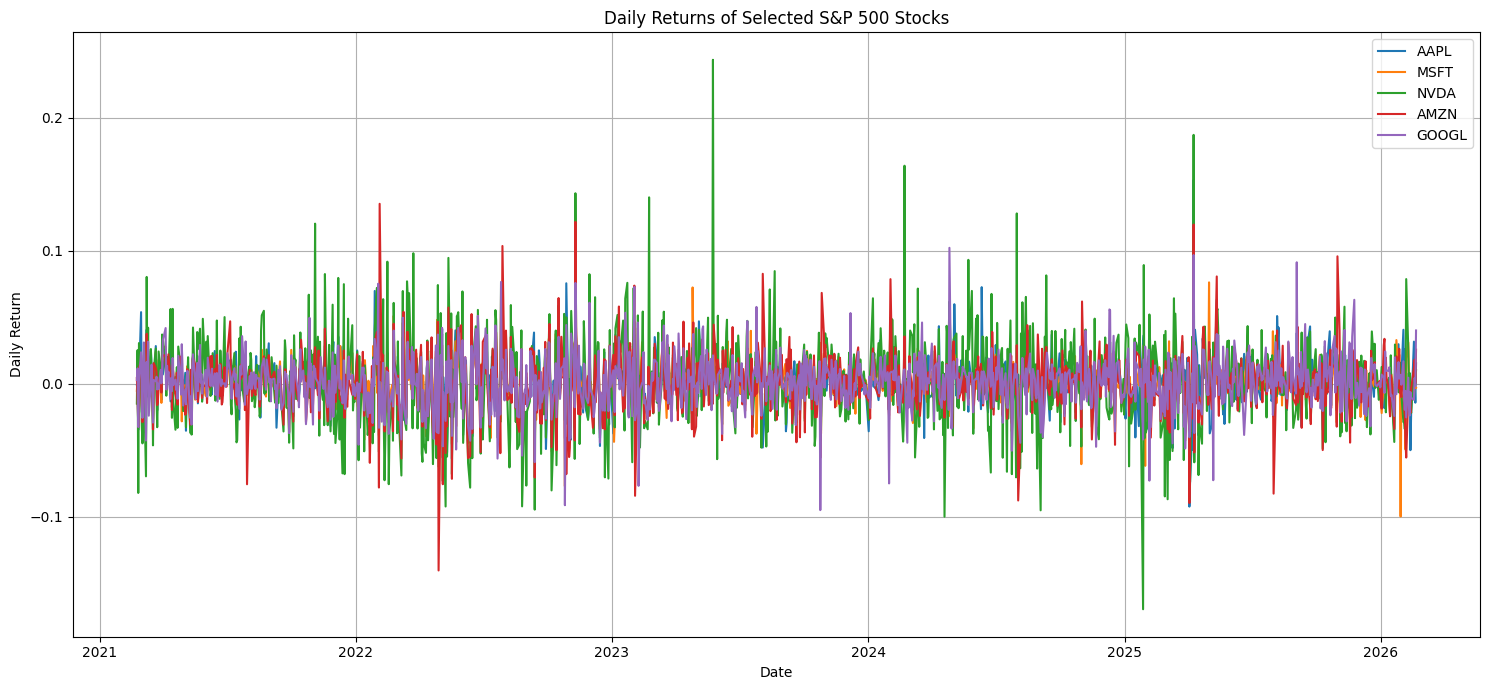

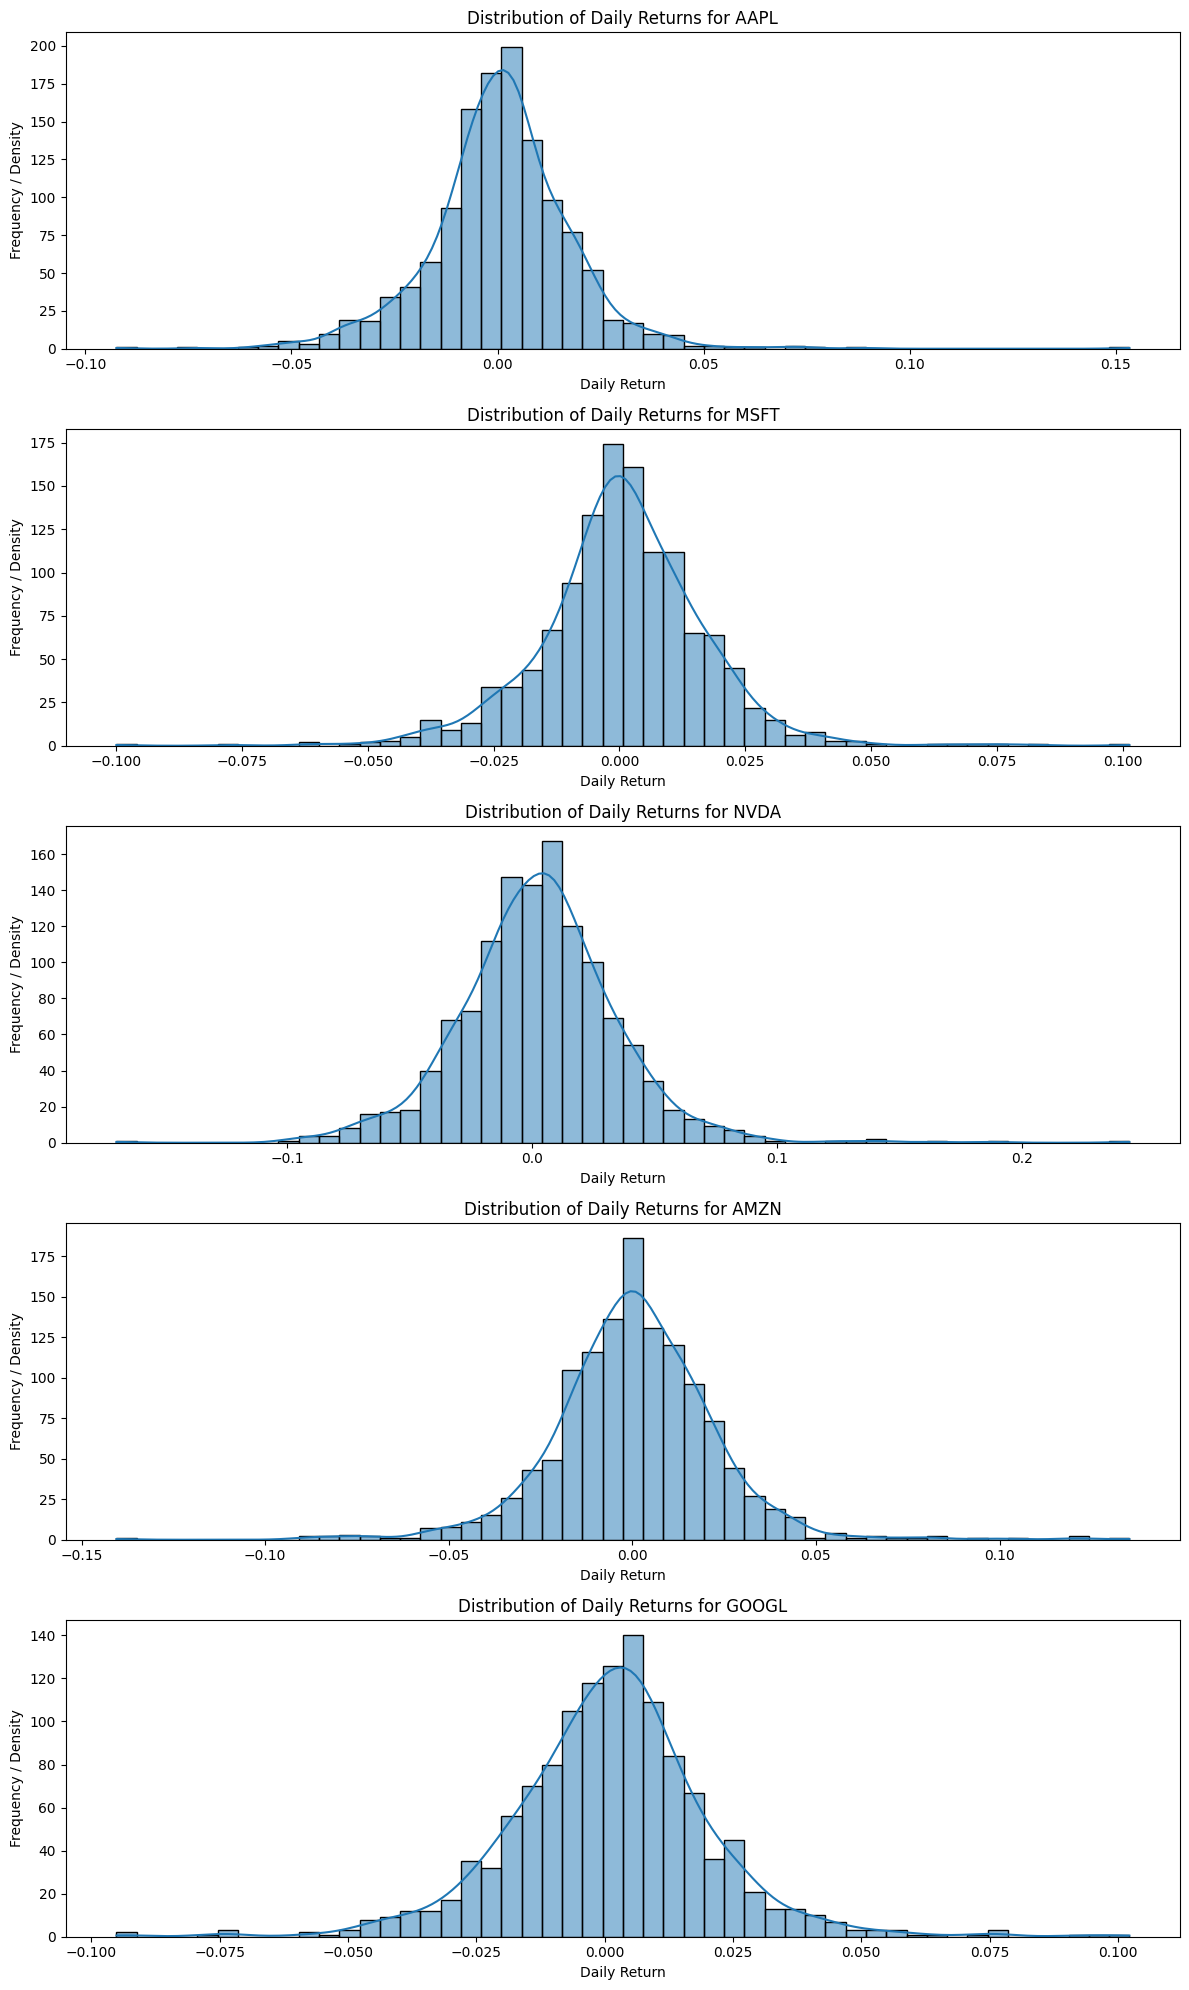

/tmp/ipython-input-357146007.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combined_volatility.index, y=combined_volatility.values, palette='viridis')


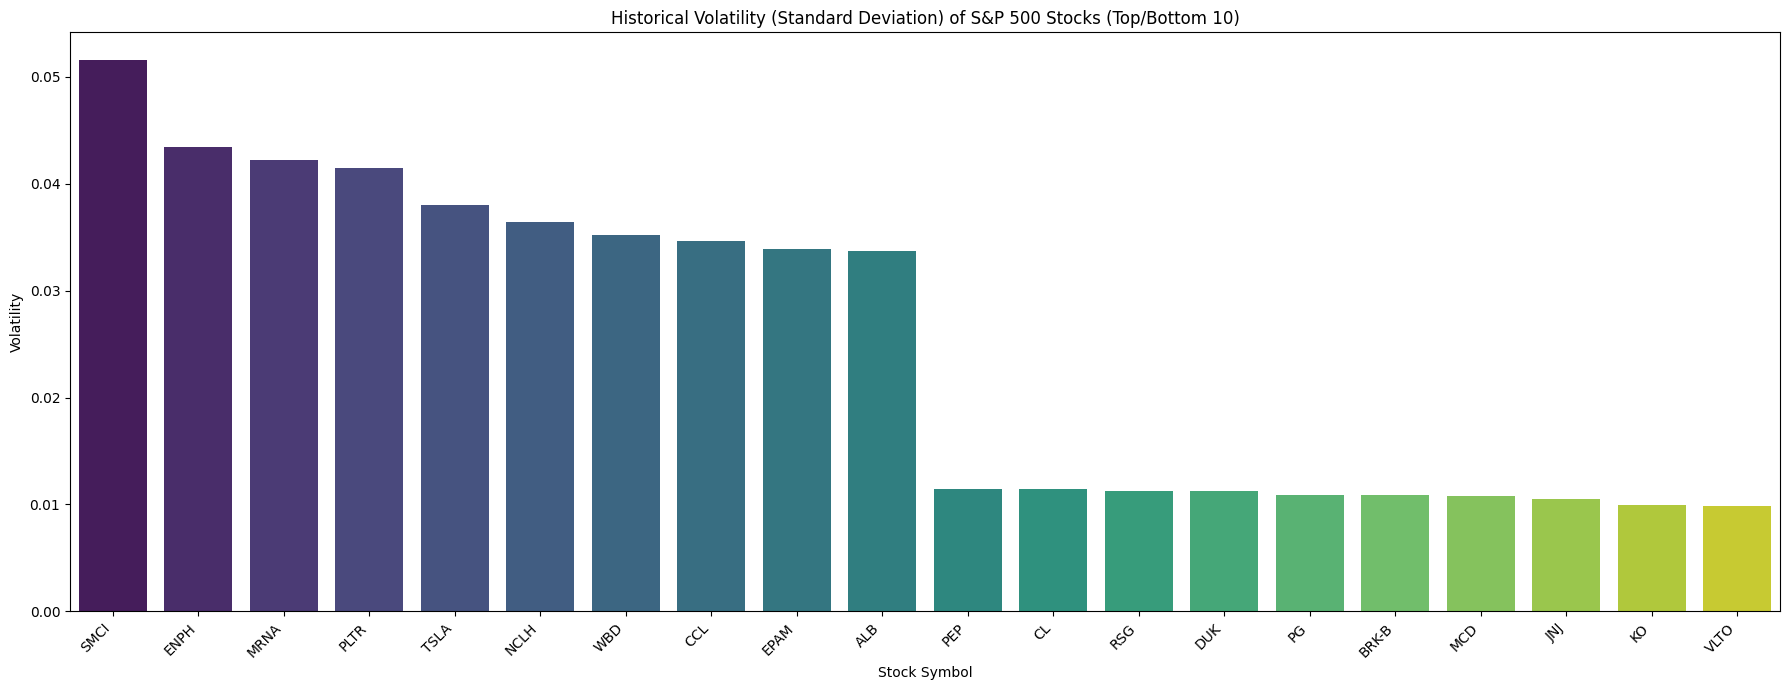

/tmp/ipython-input-357146007.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combined_var.index, y=combined_var.values, palette='plasma')


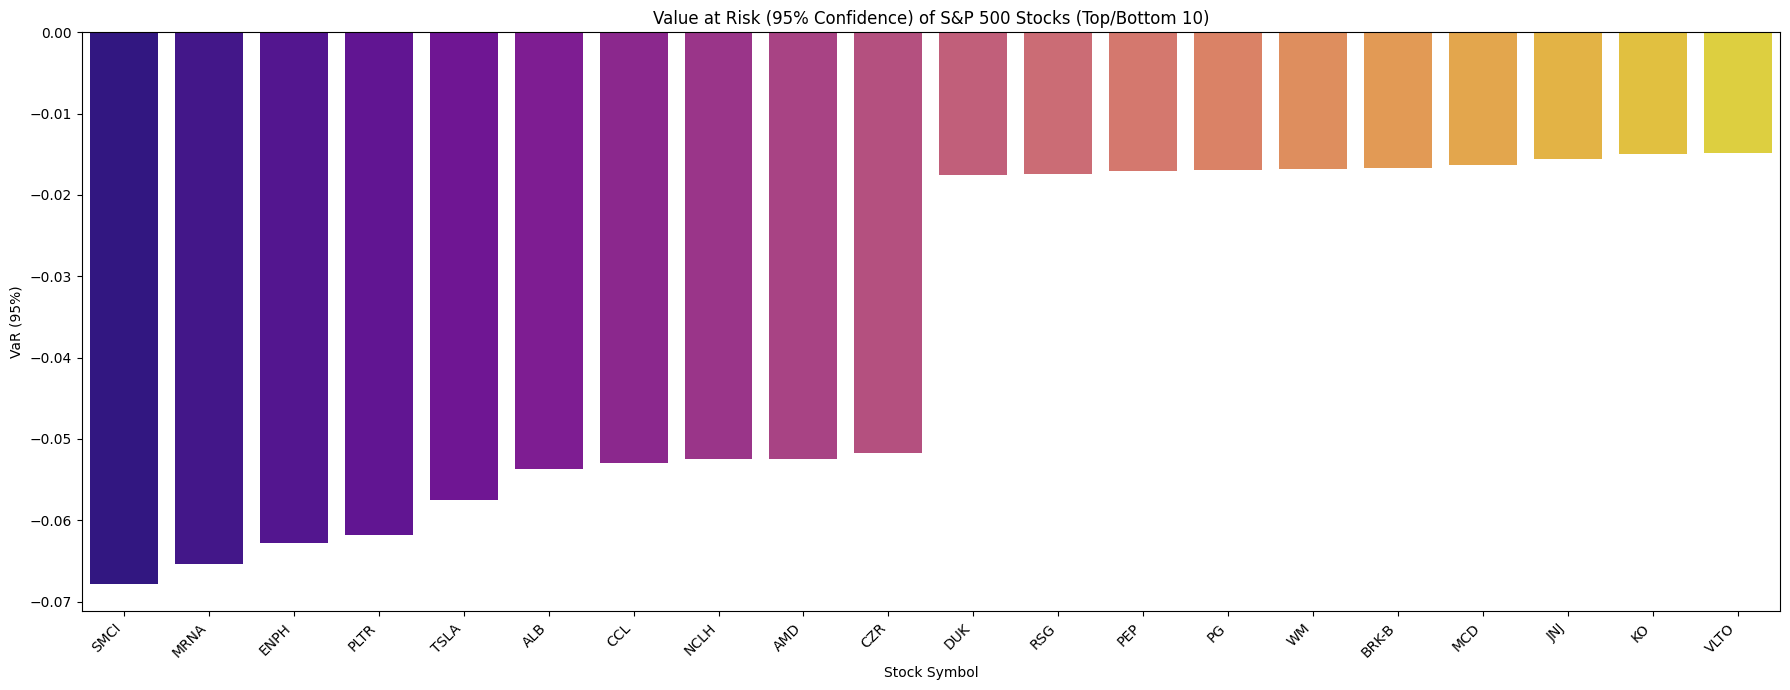

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select 3-5 stock symbols for visualization
selected_stocks = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL']

# --- Line plot for daily returns of selected stocks ---
plt.figure(figsize=(15, 7))
for stock in selected_stocks:
    if stock in daily_returns.columns:
        plt.plot(daily_returns.index, daily_returns[stock], label=stock)
    else:
        print(f"Warning: {stock} not found in daily_returns data.")

plt.title('Daily Returns of Selected S&P 500 Stocks')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Distribution of daily returns for selected stocks (histograms/KDE) ---
fig, axes = plt.subplots(len(selected_stocks), 1, figsize=(12, 4 * len(selected_stocks)))

# Ensure axes is an array even if only one stock is selected
if len(selected_stocks) == 1:
    axes = [axes]

for i, stock in enumerate(selected_stocks):
    if stock in daily_returns.columns:
        sns.histplot(daily_returns[stock].dropna(), kde=True, ax=axes[i], bins=50)
        axes[i].set_title(f'Distribution of Daily Returns for {stock}')
        axes[i].set_xlabel('Daily Return')
        axes[i].set_ylabel('Frequency / Density')
    else:
        print(f"Warning: {stock} not found for distribution plot.")

plt.tight_layout()
plt.show()

# --- Bar plot for historical volatility (top 10 most and bottom 10 least volatile) ---
# Sort volatility to get top and bottom 10
top_10_volatile = volatility.nlargest(10)
bottom_10_volatile = volatility.nsmallest(10)

# Combine for plotting, ensure no overlap if less than 20 unique stocks
combined_volatility = pd.concat([top_10_volatile, bottom_10_volatile]).sort_values(ascending=False)

plt.figure(figsize=(18, 7))
sns.barplot(x=combined_volatility.index, y=combined_volatility.values, palette='viridis')
plt.title('Historical Volatility (Standard Deviation) of S&P 500 Stocks (Top/Bottom 10)')
plt.xlabel('Stock Symbol')
plt.ylabel('Volatility')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Bar plot for VaR (top 10 highest and bottom 10 lowest VaR) ---
# Sort VaR to get top and bottom 10 (VaR is negative, so smallest (most negative) are highest risk)
# To represent 'highest VaR' as the largest potential loss (most negative return), we select the nsmallest.
# If we want to display it as positive loss values, we can take the absolute value.
# Let's consider the magnitude of loss, so sorting by magnitude or just taking nsmallest as it is negative.
# The task says 'highest VaR', which implies larger potential loss. Since VaR is typically negative, this means the most negative values.
top_10_var = var_95.nsmallest(10) # nsmallest for most negative, i.e., highest potential loss
bottom_10_var = var_95.nlargest(10) # nlargest for least negative, i.e., lowest potential loss

combined_var = pd.concat([top_10_var, bottom_10_var]).sort_values(ascending=True)

plt.figure(figsize=(18, 7))
sns.barplot(x=combined_var.index, y=combined_var.values, palette='plasma')
plt.title('Value at Risk (95% Confidence) of S&P 500 Stocks (Top/Bottom 10)')
plt.xlabel('Stock Symbol')
plt.ylabel('VaR (95%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
To eliminate the `FutureWarning` issued by Seaborn regarding the `palette` argument, I will update the `sns.barplot` calls by explicitly assigning the `x` variable to the `hue` parameter and setting `legend=False`, as suggested in the warning message. This ensures forward compatibility and maintains the intended color mapping.



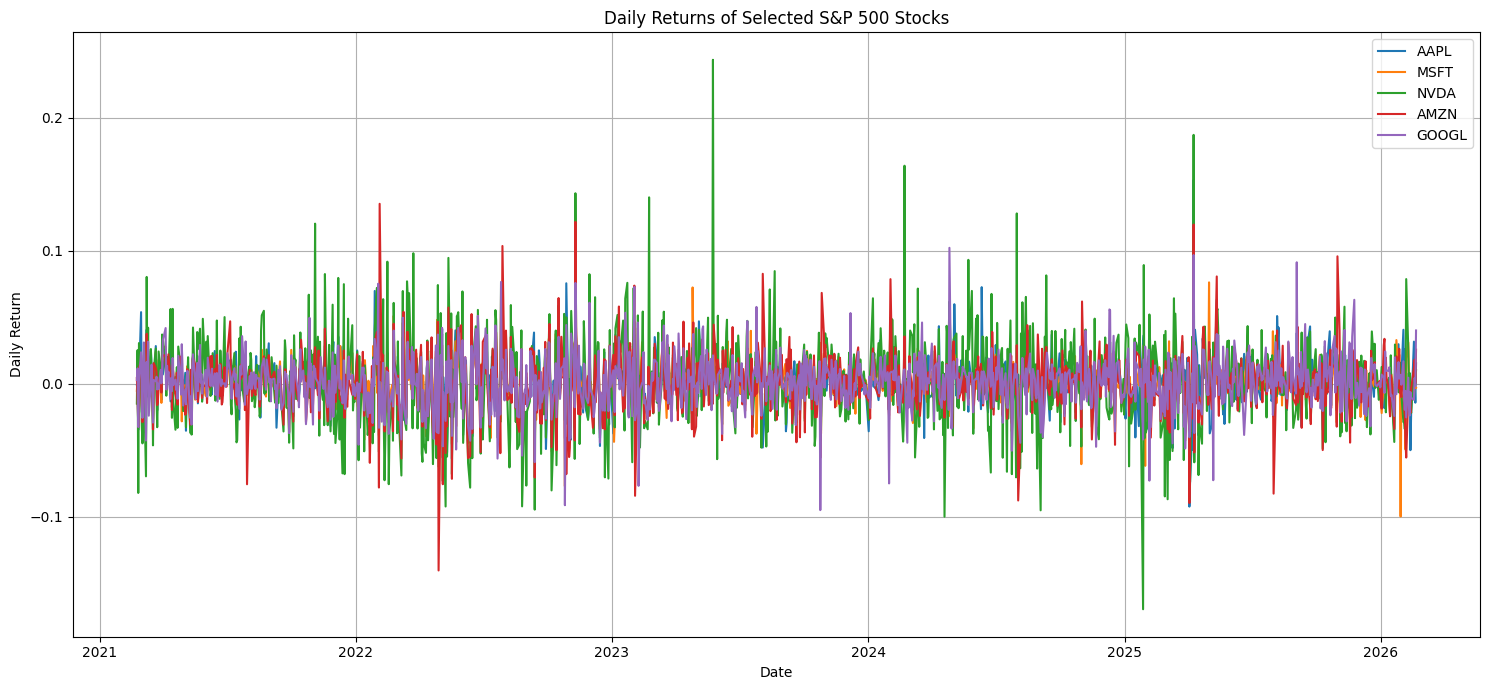

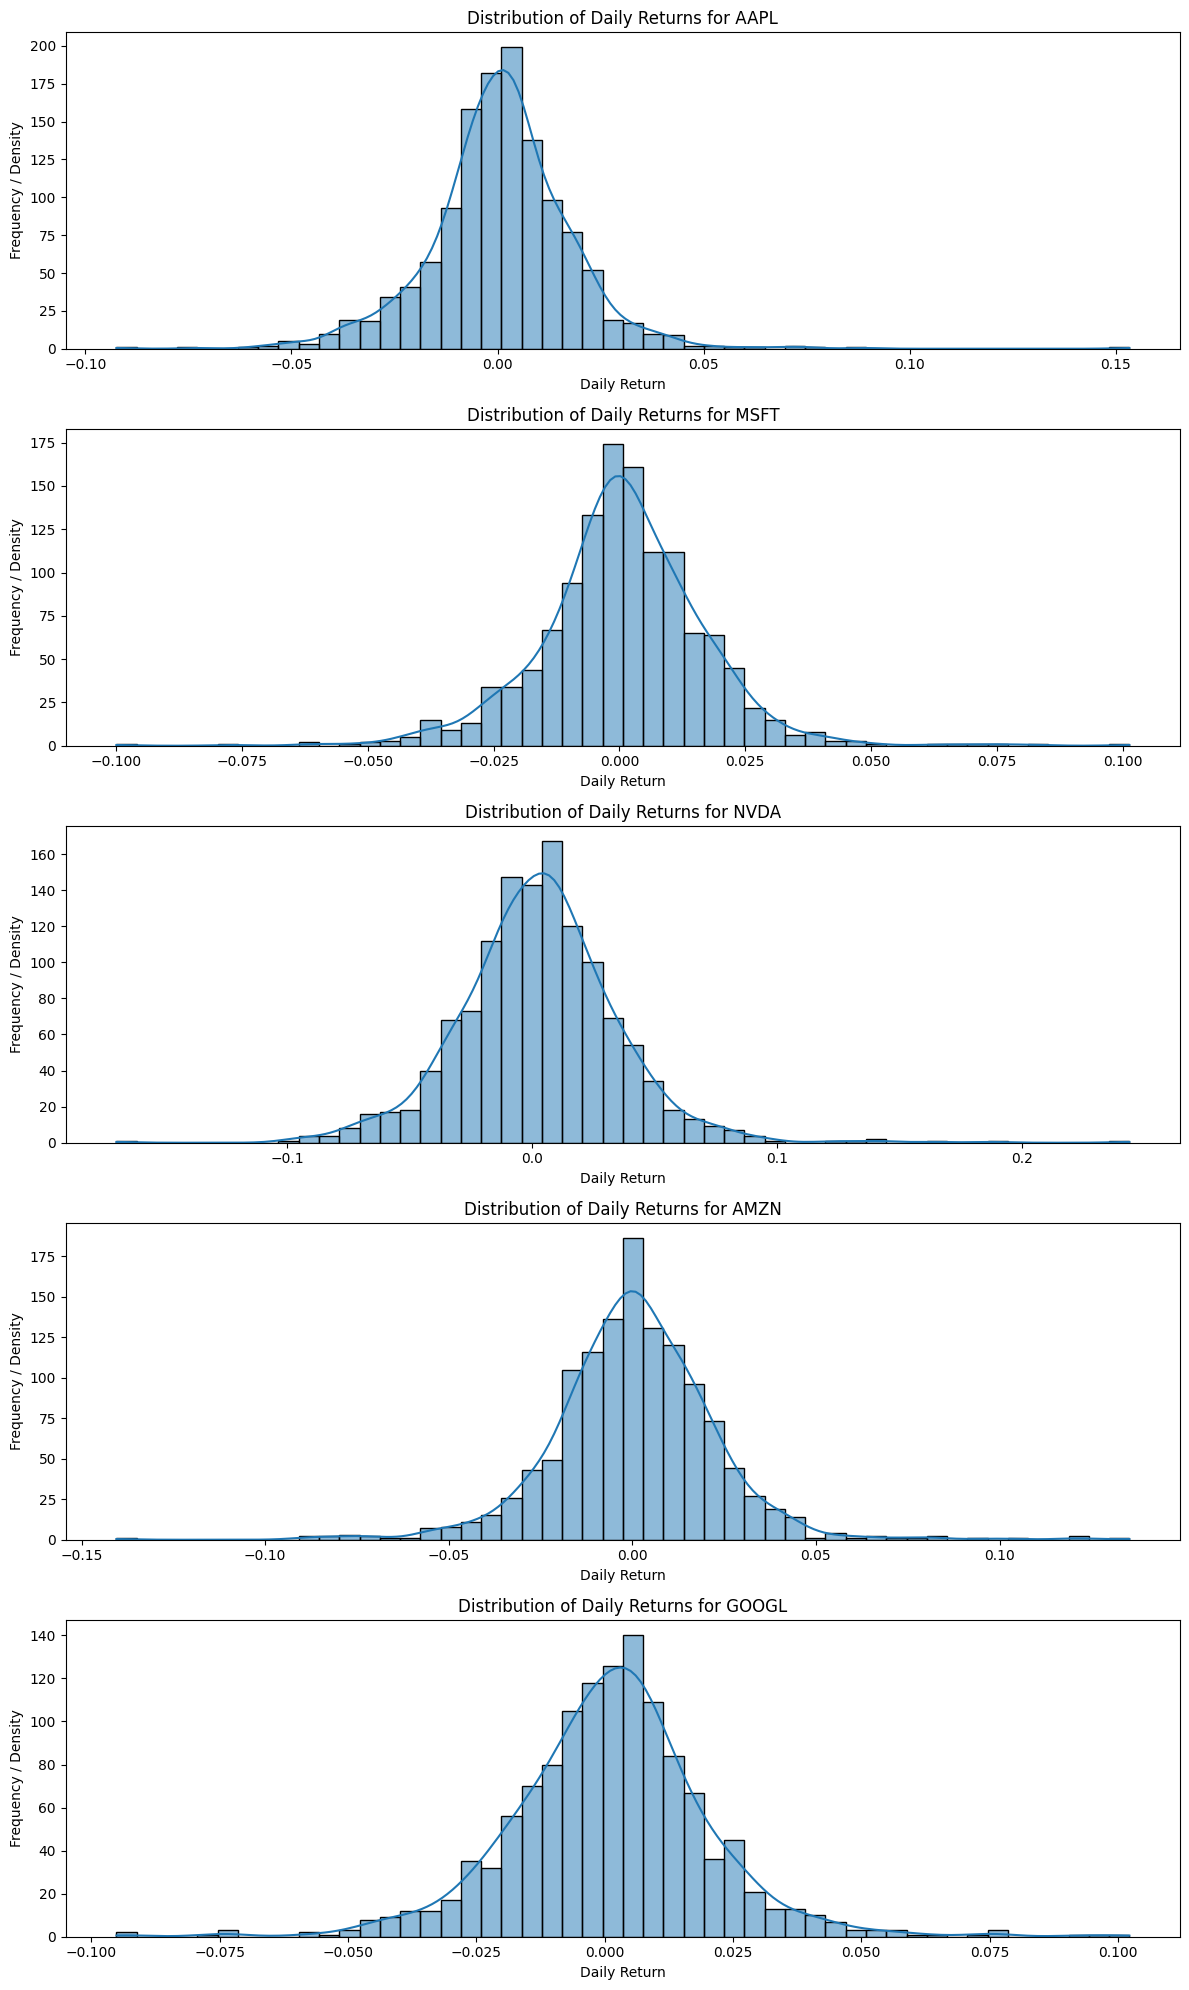

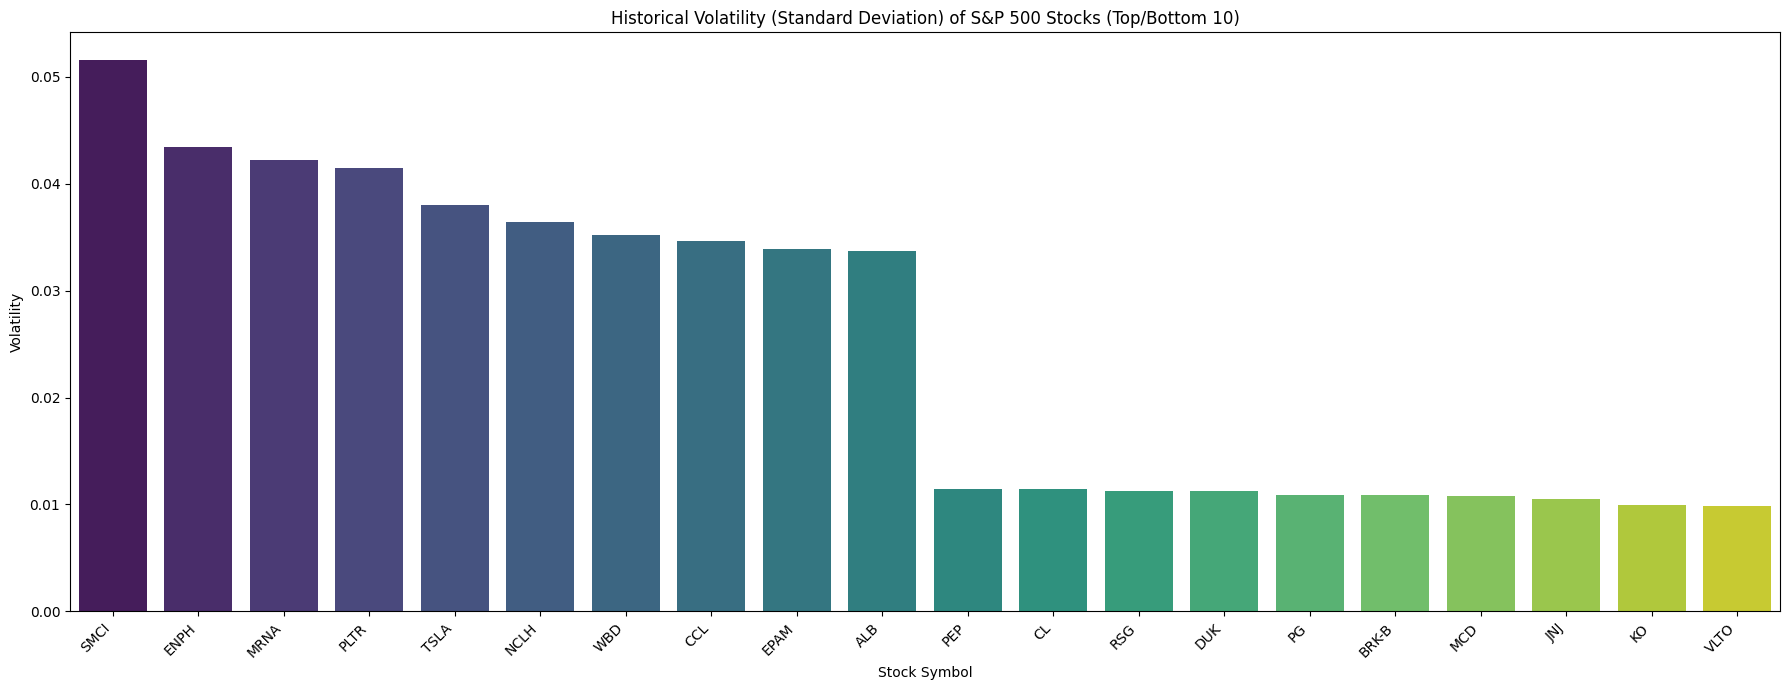

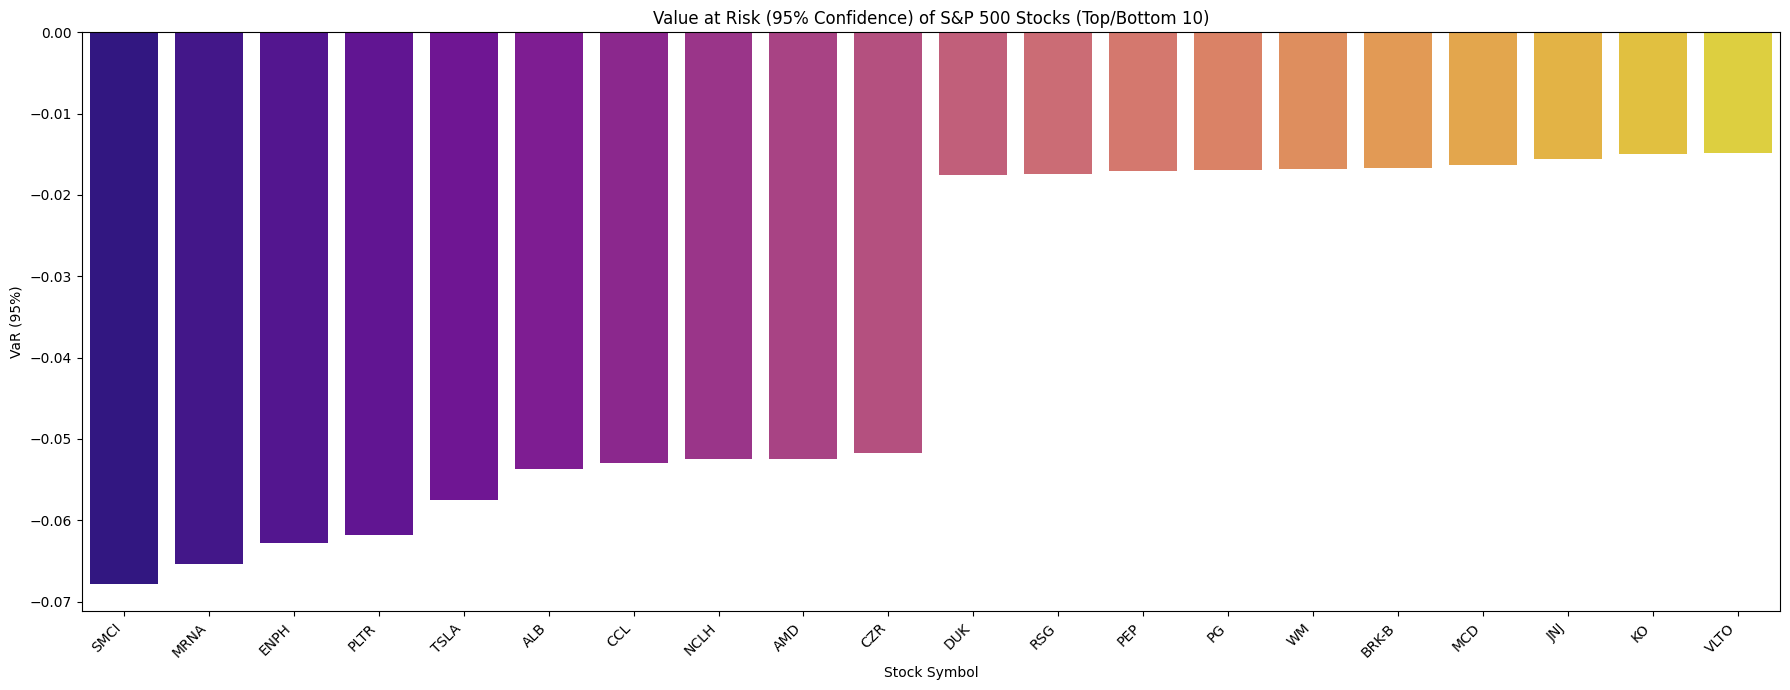

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select 3-5 stock symbols for visualization
selected_stocks = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL']

# --- Line plot for daily returns of selected stocks ---
plt.figure(figsize=(15, 7))
for stock in selected_stocks:
    if stock in daily_returns.columns:
        plt.plot(daily_returns.index, daily_returns[stock], label=stock)
    else:
        print(f"Warning: {stock} not found in daily_returns data.")

plt.title('Daily Returns of Selected S&P 500 Stocks')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Distribution of daily returns for selected stocks (histograms/KDE) ---
fig, axes = plt.subplots(len(selected_stocks), 1, figsize=(12, 4 * len(selected_stocks)))

# Ensure axes is an array even if only one stock is selected
if len(selected_stocks) == 1:
    axes = [axes]

for i, stock in enumerate(selected_stocks):
    if stock in daily_returns.columns:
        sns.histplot(daily_returns[stock].dropna(), kde=True, ax=axes[i], bins=50)
        axes[i].set_title(f'Distribution of Daily Returns for {stock}')
        axes[i].set_xlabel('Daily Return')
        axes[i].set_ylabel('Frequency / Density')
    else:
        print(f"Warning: {stock} not found for distribution plot.")

plt.tight_layout()
plt.show()

# --- Bar plot for historical volatility (top 10 most and bottom 10 least volatile) ---
# Sort volatility to get top and bottom 10
top_10_volatile = volatility.nlargest(10)
bottom_10_volatile = volatility.nsmallest(10)

# Combine for plotting, ensure no overlap if less than 20 unique stocks
combined_volatility = pd.concat([top_10_volatile, bottom_10_volatile]).sort_values(ascending=False)

plt.figure(figsize=(18, 7))
sns.barplot(x=combined_volatility.index, y=combined_volatility.values, hue=combined_volatility.index, palette='viridis', legend=False)
plt.title('Historical Volatility (Standard Deviation) of S&P 500 Stocks (Top/Bottom 10)')
plt.xlabel('Stock Symbol')
plt.ylabel('Volatility')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Bar plot for VaR (top 10 highest and bottom 10 lowest VaR) ---
# Sort VaR to get top and bottom 10 (VaR is negative, so smallest (most negative) are highest risk)
# To represent 'highest VaR' as the largest potential loss (most negative return), we select the nsmallest.
# If we want to display it as positive loss values, we can take the absolute value.
# Let's consider the magnitude of loss, so sorting by magnitude or just taking nsmallest as it is negative.
# The task says 'highest VaR', which implies larger potential loss. Since VaR is typically negative, this means the most negative values.
top_10_var = var_95.nsmallest(10) # nsmallest for most negative, i.e., highest potential loss
bottom_10_var = var_95.nlargest(10) # nlargest for least negative, i.e., lowest potential loss

combined_var = pd.concat([top_10_var, bottom_10_var]).sort_values(ascending=True)

plt.figure(figsize=(18, 7))
sns.barplot(x=combined_var.index, y=combined_var.values, hue=combined_var.index, palette='plasma', legend=False)
plt.title('Value at Risk (95% Confidence) of S&P 500 Stocks (Top/Bottom 10)')
plt.xlabel('Stock Symbol')
plt.ylabel('VaR (95%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Summarize the key findings from the financial risk modeling, including insights from volatility and Value at Risk calculations.


## Summary:

### Data Analysis Key Findings

*   The initial dataset contained 502 S&P 500 companies with 16 columns, including company details and financial metrics. Several columns, such as 'Ebitda', 'Revenuegrowth', 'State', and 'Fulltimeemployees', had missing values.
*   Historical stock price data for 493 out of 502 S&P 500 companies was successfully retrieved, with 9 companies failing to download due to unavailable data. Missing values in the historical price data were handled using forward-fill and backward-fill methods.
*   Daily returns were calculated for all 493 stocks.
*   The mean daily volatility (standard deviation of daily returns) across all S&P 500 stocks was approximately 0.0193, with a median of 0.0180.
*   The 95% Value at Risk (VaR) was calculated, indicating that on 5% of days, an average stock in the analyzed portfolio could expect to lose at least 2.85% (mean VaR of -0.0285) of its value. The median VaR was -0.0266.
*   Key financial risk metrics, including daily returns, their distributions, historical volatility, and Value at Risk, were successfully visualized. These visualizations highlighted the most and least volatile stocks, and those with the highest and lowest potential downside risk.

### Insights or Next Steps

*   The current VaR calculation provides a snapshot of downside risk. A valuable next step would be to backtest the VaR model using historical data to assess its accuracy and reliability.
*   Given the identified companies with the highest volatility and VaR, further in-depth analysis into their specific industry, business models, or recent news could provide deeper insights into the drivers of their higher financial risk.
